# Transfer Learning in RUL Estimation
## Settings

In [1]:
## Import libraries in python
import argparse
import time
import json
import logging
import sys
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from itertools import repeat
from scipy.stats import randint, expon, uniform

import tensorflow as tf
import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt
import cv2
import io
from PIL import Image
from numba import jit, cuda


# Ignore tf err log
pd.options.mode.chained_assignment = None  # default='warn'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

# random seed predictable
seed = 0
random.seed(seed)
np.random.seed(seed)

# Path settings
current_dir = '.'#os.path.dirname(os.path.abspath(__file__))

## Dataset path
train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

train_FD002_path = current_dir +'/cmapss/train_FD002.csv'
test_FD002_path = current_dir +'/cmapss/test_FD002.csv'
RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

train_FD003_path = current_dir +'/cmapss/train_FD003.csv'
test_FD003_path = current_dir +'/cmapss/test_FD003.csv'
RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

train_FD004_path =current_dir +'/cmapss/train_FD004.csv'
test_FD004_path = current_dir +'/cmapss/test_FD004.csv'
RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]

## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']

## Read csv file to pandas dataframe
FD_path = ["none", FD001_path, FD002_path, FD003_path, FD004_path]
dp_str = ["none", "FD001", "FD002", "FD003", "FD004"]

## temporary model path for NN
model_path = current_dir +'/temp_net.h5'

# Sensors not to be considered (those that do not disclose any pattern in their ts)
sensor_drop = ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

#start = time.time()

# Architecture preferences
dp = FD_path[1]
subdataset = dp_str[1]
sequence_length = 32
thres_type = None
thres_value = 50
device = 'cpu'
method = 'rps'
epochs = 50
batch = 100
verbose = 1
flatten = False
visualize = False



## Recurrent Plot File

In [2]:
'''
Created on April , 2021
@author:
'''
import logging
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from pyts.approximation import SymbolicFourierApproximation


def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.

    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]



class input_gen(object):
    '''
    class for data preparation (rps generator)
    '''

    def __init__(self, data_path_list, sequence_length, sensor_drop, piecewise_lin_ref=125, preproc=False, visualize=True):
        '''
        :param data_path_list: python list of four sub-dataset
        :param sequence_length: legnth of sequence (sliced time series)
        :param sensor_drop: sensors not to be considered
        :param piecewise_lin_ref: max rul value (if real rul value is larger than piecewise_lin_ref,
        then the rul value is piecewise_lin_ref)
        :param preproc: preprocessing
        '''
        # self.__logger = logging.getLogger('data preparation for using it as the network input')
        self.data_path_list = data_path_list
        self.sequence_length = sequence_length
        self.sensor_drop = sensor_drop
        self.preproc = preproc
        self.piecewise_lin_ref = piecewise_lin_ref
        self.visualize = visualize


        ## Assign columns name
        cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
        cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
        col_rul = ['RUL_truth']

        train_FD = pd.read_csv(self.data_path_list[0], sep=' ', header=None,
                               names=cols, index_col=False)
        test_FD = pd.read_csv(self.data_path_list[1], sep=' ', header=None,
                              names=cols, index_col=False)
        RUL_FD = pd.read_csv(self.data_path_list[2], sep=' ', header=None,
                             names=col_rul, index_col=False)

        ## Calculate RUL and append to train data
        # get the time of the last available measurement for each unit
        mapper = {}
        for unit_nr in train_FD['unit_nr'].unique():
            mapper[unit_nr] = train_FD['cycles'].loc[train_FD['unit_nr'] == unit_nr].max()

        # calculate RUL = time.max() - time_now for each unit
        train_FD['RUL'] = train_FD['unit_nr'].apply(lambda nr: mapper[nr]) - train_FD['cycles']
        # piecewise linear for RUL labels
        train_FD['RUL'].loc[(train_FD['RUL'] > self.piecewise_lin_ref)] = self.piecewise_lin_ref

        # Cut max RUL ground truth
        RUL_FD['RUL_truth'].loc[(RUL_FD['RUL_truth'] > self.piecewise_lin_ref)] = self.piecewise_lin_ref

        ## Excluse columns which only have NaN as value
        cols_nan = train_FD.columns[train_FD.isna().any()].tolist()
        cols_const = [col for col in train_FD.columns if len(train_FD[col].unique()) <= 2]

        ## Drop exclusive columns
        # train_FD = train_FD.drop(columns=cols_const + cols_nan)
        # test_FD = test_FD.drop(columns=cols_const + cols_nan)

        train_FD = train_FD.drop(columns=cols_const + cols_nan + sensor_drop)

        test_FD = test_FD.drop(columns=cols_const + cols_nan + sensor_drop)


        if self.preproc == True:
            ## preprocessing(normailization for the neural networks)
            min_max_scaler = preprocessing.MinMaxScaler()
            # for the training set
            # train_FD['cycles_norm'] = train_FD['cycles']
            cols_normalize = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])

            norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_FD[cols_normalize]),
                                         columns=cols_normalize,
                                         index=train_FD.index)
            join_df = train_FD[train_FD.columns.difference(cols_normalize)].join(norm_train_df)
            train_FD = join_df.reindex(columns=train_FD.columns)

            # for the test set
            # test_FD['cycles_norm'] = test_FD['cycles']
            cols_normalize_test = test_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2'])
            # print ("cols_normalize_test", cols_normalize_test)
            norm_test_df = pd.DataFrame(min_max_scaler.transform(test_FD[cols_normalize_test]), columns=cols_normalize_test,
                                        index=test_FD.index)
            test_join_df = test_FD[test_FD.columns.difference(cols_normalize_test)].join(norm_test_df)
            test_FD = test_join_df.reindex(columns=test_FD.columns)
            test_FD = test_FD.reset_index(drop=True)
        else:
            # print ("No preprocessing")
            pass

        # Specify the columns to be used
        sequence_cols_train = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])
        sequence_cols_test = test_FD.columns.difference(['unit_nr', 'os_1', 'os_2', 'cycles'])



        ## generator for the sequences
        # transform each id of the train dataset in a sequence
        seq_gen = (list(gen_sequence(train_FD[train_FD['unit_nr'] == id], self.sequence_length, sequence_cols_train))
                   for id in train_FD['unit_nr'].unique())

        # generate sequences and convert to numpy array in training set
        seq_array_train = np.concatenate(list(seq_gen)).astype(np.float32)
        self.seq_array_train = seq_array_train.transpose(0, 2, 1) # shape = (samples, sensors, sequences)
        # print("seq_array_train.shape", self.seq_array_train.shape)

        # generate label of training samples
        label_gen = [gen_labels(train_FD[train_FD['unit_nr'] == id], self.sequence_length, ['RUL'])
                     for id in train_FD['unit_nr'].unique()]
        self.label_array_train = np.concatenate(label_gen).astype(np.float32)

        # generate sequences and convert to numpy array in test set (only the last sequence for each engine in test set)
        seq_array_test_last = [test_FD[test_FD['unit_nr'] == id][sequence_cols_test].values[-self.sequence_length:]
                               for id in test_FD['unit_nr'].unique() if
                               len(test_FD[test_FD['unit_nr'] == id]) >= self.sequence_length]

        seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
        self.seq_array_test_last = seq_array_test_last.transpose(0, 2, 1) # shape = (samples, sensors, sequences)
        # print("seq_array_test_last.shape", self.seq_array_test_last.shape)

        # generate label of test samples
        y_mask = [len(test_FD[test_FD['unit_nr'] == id]) >= self.sequence_length for id in test_FD['unit_nr'].unique()]
        label_array_test_last = RUL_FD['RUL_truth'][y_mask].values
        self.label_array_test = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)


        ## Visualize Run-2-failure TS of the first engine in the training set.(Please deactivate after understanding)
        if self.visualize == True:
            # R2F TS of the first engine
            pd.DataFrame(train_FD[train_FD['unit_nr'] == 1][sequence_cols_train].values,
                             columns=sequence_cols_train).plot(subplots=True, figsize=(15, 15))

            # The last sequences sliced from each TS (of the first engine)
            prop_cycle = plt.rcParams['axes.prop_cycle']
            colors = prop_cycle.by_key()['color']
            colors = colors + colors + colors

            seq_gen = (
            list(gen_sequence(train_FD[train_FD['unit_nr'] == id], self.sequence_length, sequence_cols_train))
            for id in train_FD['unit_nr'].unique())

            seq_list_engine = list(seq_gen)
            seq_engine_1_array = np.asarray(seq_list_engine[0])

            last_seq_engine_1_array = seq_engine_1_array[-1, :, :]
            fig_ts = plt.figure(figsize=(15, 15))
            for s in range(last_seq_engine_1_array.shape[1]):
                seq_s = last_seq_engine_1_array[:, s]
                # plt.subplot(last_seq_engine_1_array.shape[1],(s//4) + 1, (s%4)+1)
                plt.subplot(4, 4, s + 1)
                plt.plot(seq_s, "y", label=sequence_cols_train[s], color=colors[s])
                plt.legend()

            plt.xlabel("time(cycles)")
            plt.show()


    def rps(self, thres_type=None, thres_percentage=50, flatten=False, visualize=True):
        '''
        generate RPs from sequences
        :param thres_type:  ‘point’, ‘distance’ or None (default = None)
        :param thres_percentage:
        :param flatten:
        :param visualize: visualize generated RPs (first training sample)
        :return: PRs (samples for NNs and their label)
        '''

        # Recurrence plot transformation for training samples
        rp_train = RecurrencePlot(threshold=thres_type, percentage=thres_percentage,flatten=flatten)

        rp_list = []
        for idx in range(self.seq_array_train.shape[0]):
            temp_mts = self.seq_array_train[idx]
            # print (temp_mts.shape)
            X_rp_temp = rp_train.fit_transform(temp_mts)
            # print (X_rp_temp.shape)
            rp_list.append(X_rp_temp)

        rp_train_samples = np.stack(rp_list, axis=0)

        # Recurrence plot transformation for test samples
        rp_test = RecurrencePlot(threshold=thres_type, percentage=thres_percentage, flatten=flatten)
        rp_list = []
        for idx in range(self.seq_array_test_last.shape[0]):
            temp_mts = self.seq_array_test_last[idx]
            # print (temp_mts.shape)
            X_rp_temp = rp_test.fit_transform(temp_mts)
            # print (X_rp_temp.shape)
            rp_list.append(X_rp_temp)
        rp_test_samples = np.stack(rp_list, axis=0)

        label_array_train = self.label_array_train
        label_array_test = self.label_array_test

        # Visualize RPs of the last sequences sliced from each TS (of the first engine)
        if visualize == True:
            X_rp = rp_train_samples[-1]
            plt.figure(figsize=(15, 15))
            for s in range(len(X_rp)):
                # plt.subplot(last_seq_engine_1_array.shape[1],(s//4) + 1, (s%4)+1)
                plt.subplot(4, 4, s + 1)
                if flatten == True:
                    img = np.atleast_2d(X_rp[s])
                    plt.imshow(img, extent=(0, img.shape[1], 0, round(img.shape[1]/9)))
                else:
                    plt.imshow(X_rp[s], origin='lower')
                # plt.legend()
            plt.show()

        return  rp_train_samples, label_array_train, rp_test_samples, label_array_test


In [3]:
data_class = input_gen(data_path_list=dp, 
                       sequence_length=sequence_length,
                       preproc = True, 
                       sensor_drop= sensor_drop, 
                       visualize=visualize)

In [4]:
if method == 'rps':
    train_samples, label_array_train, test_samples, label_array_test = data_class.rps(
        thres_type=thres_type,
        thres_percentage=thres_value,
        flatten=flatten,
        visualize=visualize)

elif method == 'jrp': # please implement any method if needed
    pass

In [5]:
train_samples.shape

(17431, 14, 32, 32)

In [6]:
# def change_format(X_rp):
#     '''
#     Takes 14 sensors array (32x32) and reshapes into 1 array(128x128)
#     '''
#     # 1- Create two dummy zero arrays with np.zeros(32,32)
#     temp = np.zeros((64,32))
#     # 2- Concatenate all 16 arrays
#     for i in range(len(X_rp)):
#         x = X_rp[i]
#         temp = np.concatenate((temp,x), axis=0)

#     # 3- Reshape the concatenated arrays to (128,128)
#     new_train0 = temp.reshape(128,128)
#     # 4- Extract RGB channels with cv2.split(img)
#     ## To make a figure without the frame
#     my_dpi = 96
#     array_size = 128
#     fig = plt.figure(figsize=(array_size/my_dpi, array_size/my_dpi), dpi=my_dpi, frameon=False)
#     ## To make the content fill the whole figure
#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)
#     ## Drawing image
#     ax.imshow(new_train0)
#     fig.savefig('img1.png', dpi = my_dpi)
#     img = cv2.imread('img1.png')
#     plt.close(fig)
    
#     return np.asarray(cv2.split(img))

def change_format(X_rp):
    '''
    Takes 14 sensors array (32x32) and reshapes into 1 array(128x128)
    '''
    dummy_array = np.zeros((64,32))
    temp_row = np.array([]).reshape(0,len(X_rp[0]))
    temp_array = np.array([]).reshape(len(X_rp[0])*4,0)
    for i in range(len(X_rp)):
    # print ("temp_row.shape", temp_row.shape)
    # print ("temp_array.shape", temp_array.shape)        
        x = X_rp[i]
        # temp_row = np.concatenate((temp_row,x), axis=0)
        temp_row = np.vstack([temp_row,x])
        if (i+1)%4 == 0:
            temp_array = np.hstack([temp_array, temp_row])
            temp_row = np.array([]).reshape(0,len(X_rp[0]))
        if (i+1)==len(X_rp):
            temp_row = np.vstack([temp_row,dummy_array])
            temp_array = np.hstack([temp_array, temp_row])
            temp_row = np.array([]).reshape(0,len(X_rp[0]))   
    # plt.figure(figsize=(10, 10))
    # plt.imshow(temp_array, origin='lower')
    # plt.show()
    new_train0 = temp_array
    # 4- Extract RGB channels with cv2.split(img)
    ## To make a figure without the frame
    my_dpi = 96
    array_size = 128
    fig = plt.figure(figsize=(array_size/my_dpi, array_size/my_dpi), dpi=my_dpi, frameon=False)
    ## To make the content fill the whole figure
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ## Drawing image
    ax.imshow(new_train0)
    fig.savefig('img1.png', dpi = my_dpi)
    img = cv2.imread('img1.png')
    plt.close(fig)
    return  np.asarray(cv2.split(img))

In [7]:
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

def format_samples(train_samples, test_samples):
    '''
    Format training and test sets (n_samples, image_size, channels)
    '''
    start = time.time()
    resh_train = np.asarray([change_format(rp) for rp in train_samples])
    end = time.time()
    print("Reshape train time: ")
    timer(start,end)
    start = time.time()
    resh_test = np.asarray([change_format(rp) for rp in test_samples])
    end = time.time()
    print("Reshape test time: ")
    timer(start,end)
    return resh_train, resh_test

In [8]:
train_samples, test_samples = format_samples(train_samples, test_samples)

Reshape train time: 
00:11:09.00
Reshape test time: 
00:00:03.73


In [9]:
print ("train_samples.shape: ", train_samples.shape) # shape = (samples, channels, height, width)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, channels, height, width)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)

train_samples = np.transpose(train_samples, (0,2,3,1))
test_samples = np.transpose(test_samples, (0,2,3,1))

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, height, width, channels)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)


train_samples.shape:  (17431, 3, 128, 128)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 3, 128, 128)
label_array_test.shape:  (99, 1)
train_samples.shape:  (17431, 128, 128, 3)
label_array_train.shape:  (17431, 1)
test_samples.shape:  (99, 128, 128, 3)
label_array_test.shape:  (99, 1)


# Network

In [10]:
import time
import json
import logging as log
import sys

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error

from math import sqrt
# import keras
import tensorflow as tf
print(tf.__version__)

# import keras.backend as K
import tensorflow.keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Embedding
from tensorflow.keras.layers import BatchNormalization, Activation, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)


def gen_net(model_name, weights, freeze):
    '''
    TODO: Implement other cnn model
    Todo: Freezing only few layers (read papers)
    :param model_name: vgg, inception
    :param weights: True/False
    :param pretrain: True/False
    :return:
    '''
    
    if(model_name == "vgg"):
        if(weights == True):
            model = VGG16(
                input_shape=(128,128,3), 
                weights = 'imagenet', 
                include_top = False)
        else:
            model = VGG16(
                input_shape=(128,128,3), 
                weights = None, 
                include_top = False)
    
    if(model_name == "inception"):
        if(weights == True):
            model = InceptionV3(
                input_shape=(128,128,3), 
                weights = 'imagenet', 
                include_top = False)
        else:
            model = InceptionV3(
                input_shape=(128,128,3),
                weights = None, 
                include_top = False)

    # This section has to be modified in order a pre defined number of layers
    if(freeze):
        for layer in model.layers:
            layer.trainable = False

    
    base_outputs = model.output
    flatten_outputs = Flatten()(base_outputs)
    final_outputs = Dense(1)(flatten_outputs)
    new_model = Model(inputs = model.input, outputs = final_outputs) 
    new_model.summary()

    return new_model


# def gen_net(vec_len, num_hidden1, num_hidden2 ):
#     '''
#     TODO: Generate and evaluate any CNN instead of MLPs
#     :param vec_len:
#     :param num_hidden1:
#     :param num_hidden2:
#     :return:
#     '''

#     model = Sequential()
#     model.add(Dense(num_hidden1, activation='relu', input_shape=(vec_len,)))
#     model.add(Dense(num_hidden2, activation='relu'))
#     model.add(Dense(1))

#     return model

class network_fit(object):
    '''
    class for network
    '''

    def __init__(self, train_samples, label_array_train, test_samples, label_array_test,
                 model_path, model_name, weights, freeze, verbose=1):
        '''
        Constructor
        Generate a CNN and train
        @param none
        '''
        # self.__logger = logging.getLogger('data preparation for using it as the network input')
        self.train_samples = train_samples
        self.label_array_train = label_array_train
        self.test_samples = test_samples
        self.label_array_test = label_array_test
        self.model_path = model_path
        self.verbose = verbose

        # self.mlps = gen_net(self.train_samples.shape[1], self.n_hidden1, self.n_hidden2)
        self.mlps = gen_net(model_name, weights, freeze)



    def train_net(self, epochs, batch_size, lr= 1e-05, plotting=False):
        '''
        specify the optimizers and train the network
        :param epochs:
        :param batch_size:
        :param lr:
        :return:
        '''
        print("Initializing network...")
        # compile the model
        rp = optimizers.RMSprop(learning_rate=lr, rho=0.9, centered=True)
        adm = optimizers.Adam(learning_rate=lr, epsilon=1)
        sgd_m = optimizers.SGD(learning_rate=lr)

        keras_rmse = tf.keras.metrics.RootMeanSquaredError()
        self.mlps.compile(loss='mean_squared_error', optimizer=adm, metrics=[keras_rmse, 'mae'])

        print(self.mlps.summary())

        # Train the model
        history = self.mlps.fit(self.train_samples, self.label_array_train, epochs=epochs, batch_size=batch_size,
                                validation_split=0.2, verbose=self.verbose,
                                callbacks=[
                               EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0, patience=50, verbose=self.verbose, mode='min'),
                               ModelCheckpoint(self.model_path, monitor='val_root_mean_squared_error', save_best_only=True, mode='min',
                                               verbose=self.verbose)])

        val_rmse_k = history.history['val_root_mean_squared_error']
        val_rmse_min = min(val_rmse_k)
        min_val_rmse_idx = val_rmse_k.index(min(val_rmse_k))
        stop_epoch = min_val_rmse_idx +1
        val_rmse_min = round(val_rmse_min, 4)
        print ("val_rmse_min: ", val_rmse_min)

        trained_net = self.mlps

        ## Plot training & validation loss about epochs
        if plotting == True:
            # summarize history for Loss
            fig_acc = plt.figure(figsize=(10, 10))
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.ylim(0, 2000)
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()


        return trained_net



    def test_net(self, trained_net=None, best_model=True, plotting=True):
        '''
        Evalute the trained network on test set
        :param trained_net:
        :param best_model:
        :param plotting:
        :return:
        '''
        # Load the trained model
        if best_model:
            estimator = load_model(self.model_path)
        else:
            estimator = load_model(trained_net)

        # predict the RUL
        y_pred_test = estimator.predict(self.test_samples)
        y_true_test = self.label_array_test # ground truth of test samples

        pd.set_option('display.max_rows', 1000)
        test_print = pd.DataFrame()
        test_print['y_pred'] = y_pred_test.flatten()
        test_print['y_truth'] = y_true_test.flatten()
        test_print['diff'] = abs(y_pred_test.flatten() - y_true_test.flatten())
        test_print['diff(ratio)'] = abs(y_pred_test.flatten() - y_true_test.flatten()) / y_true_test.flatten()
        test_print['diff(%)'] = (abs(y_pred_test.flatten() - y_true_test.flatten()) / y_true_test.flatten()) * 100

        y_predicted = test_print['y_pred']
        y_actual = test_print['y_truth']
        rms = sqrt(mean_squared_error(y_actual, y_predicted)) # RMSE metric
        test_print['rmse'] = rms
        print(test_print)


        # Score metric
        h_array = y_predicted - y_actual
        s_array = np.zeros(len(h_array))
        for j, h_j in enumerate(h_array):
            if h_j < 0:
                s_array[j] = math.exp(-(h_j / 13)) - 1

            else:
                s_array[j] = math.exp(h_j / 10) - 1
        score = np.sum(s_array)

        # Plot the results of RUL prediction
        if plotting == True:
            fig_verify = plt.figure(figsize=(12, 6))
            plt.plot(y_pred_test, color="blue")
            plt.plot(y_true_test, color="green")
            plt.title('prediction')
            plt.ylabel('value')
            plt.xlabel('row')
            plt.legend(['predicted', 'actual data'], loc='upper left')
            plt.show()

        return rms, score

2.4.1


# Inception + Weights + Freeze

In [11]:
# Creo l'oggetto net
mlps_net = network_fit(train_samples, 
                       label_array_train, 
                       test_samples, 
                       label_array_test,
                       model_path = model_path, 
                       model_name = "inception",
                       weights = True,
                       freeze = True,
                       verbose=verbose)


87916544/87910968 [==============================] - 11s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________

In [12]:
#Train
trained_net = mlps_net.train_net(epochs=epochs, batch_size=batch)

Initializing network...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________

batch_normalization_25 (BatchNo (None, 13, 13, 64)   192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 13, 13, 64)   0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 13, 13, 64)   0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 13, 13, 96)   0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
activation_25 (Activation)      (None, 13, 13, 64)   0           batch_normalization_25[0][0]     
__________________________________________________________________________________________________
mixed2 (Co

Epoch 1/50
140/140 [==============================] - 29s 151ms/step - loss: 6029.8220 - root_mean_squared_error: 77.3182 - mae: 66.6202 - val_loss: 2560.7754 - val_root_mean_squared_error: 50.6041 - val_mae: 44.7539

Epoch 00001: val_root_mean_squared_error improved from inf to 50.60411, saving model to ./temp_net.h5
Epoch 2/50
140/140 [==============================] - 14s 99ms/step - loss: 2051.5576 - root_mean_squared_error: 45.2798 - mae: 39.8574 - val_loss: 1951.7950 - val_root_mean_squared_error: 44.1791 - val_mae: 39.5941

Epoch 00002: val_root_mean_squared_error improved from 50.60411 to 44.17912, saving model to ./temp_net.h5
Epoch 3/50
140/140 [==============================] - 14s 99ms/step - loss: 1806.8819 - root_mean_squared_error: 42.5067 - mae: 37.3457 - val_loss: 1909.9674 - val_root_mean_squared_error: 43.7032 - val_mae: 39.1206

Epoch 00003: val_root_mean_squared_error improved from 44.17912 to 43.70317, saving model to ./temp_net.h5
Epoch 4/50
140/140 [============

140/140 [==============================] - 14s 100ms/step - loss: 1221.3118 - root_mean_squared_error: 34.9417 - mae: 30.6214 - val_loss: 1379.6855 - val_root_mean_squared_error: 37.1441 - val_mae: 33.0937

Epoch 00026: val_root_mean_squared_error improved from 37.39960 to 37.14412, saving model to ./temp_net.h5
Epoch 27/50
140/140 [==============================] - 14s 100ms/step - loss: 1199.2016 - root_mean_squared_error: 34.6287 - mae: 30.2920 - val_loss: 1364.8682 - val_root_mean_squared_error: 36.9441 - val_mae: 32.8708

Epoch 00027: val_root_mean_squared_error improved from 37.14412 to 36.94412, saving model to ./temp_net.h5
Epoch 28/50
140/140 [==============================] - 14s 100ms/step - loss: 1191.6665 - root_mean_squared_error: 34.5197 - mae: 30.1526 - val_loss: 1346.7333 - val_root_mean_squared_error: 36.6979 - val_mae: 32.5690

Epoch 00028: val_root_mean_squared_error improved from 36.94412 to 36.69786, saving model to ./temp_net.h5
Epoch 29/50
140/140 [=============

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0    68.681404     98.0  29.318596     0.299169   29.916933  29.091153
1    81.223778     69.0  12.223778     0.177156   17.715620  29.091153
2    79.477623     82.0   2.522377     0.030761    3.076070  29.091153
3    98.470222     91.0   7.470222     0.082090    8.209036  29.091153
4    75.029266     93.0  17.970734     0.193234   19.323370  29.091153
5   102.407333     91.0  11.407333     0.125355   12.535532  29.091153
6    92.053337     95.0   2.946663     0.031018    3.101750  29.091153
7    74.054779    111.0  36.945221     0.332840   33.283981  29.091153
8   102.857185     96.0   6.857185     0.071429    7.142901  29.091153
9    91.083603     97.0   5.916397     0.060994    6.099378  29.091153
10   85.031357    124.0  38.968643     0.314263   31.426325  29.091153
11   85.056152     95.0   9.943848     0.104672   10.467208  29.091153
12   89.991264    107.0  17.008736     0.158960   15.896015  29.091153
13   9

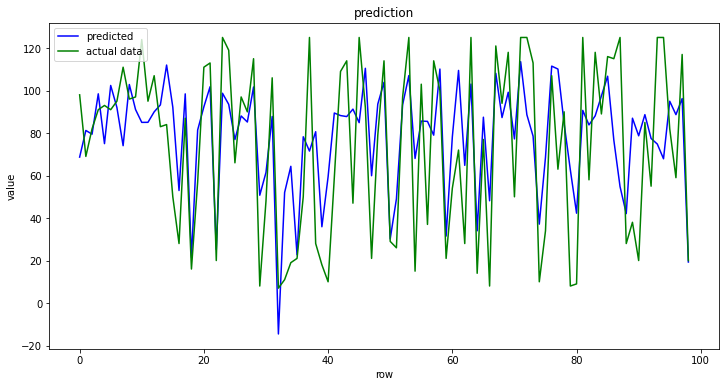

In [13]:
# Test
rms, score = mlps_net.test_net(trained_net)

In [14]:
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

FD001 test RMSE:  29.091152710328014
FD001 test Score:  2937.832368484372


# Inception + Weights + No Freeze

In [15]:
# Creo l'oggetto net
mlps_net = network_fit(train_samples, 
                       label_array_train, 
                       test_samples, 
                       label_array_test,
                       model_path = model_path, 
                       model_name = "inception",
                       weights = True,
                       freeze = False,
                       verbose=verbose)
#Train
trained_net = mlps_net.train_net(epochs=epochs, batch_size=batch)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 63, 63, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 63, 63, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
activation_117 (Activation)     (None, 13, 13, 96)   0           batch_normalization_117[0][0]    
__________________________________________________________________________________________________
average_pooling2d_11 (AveragePo (None, 13, 13, 288)  0           mixed1[0][0]                     
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 13, 13, 64)   18432       mixed1[0][0]                     
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 13, 13, 64)   76800       activation_114[0][0]             
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 13, 13, 96)   82944       activation_117[0][0]             
__________

Epoch 1/50
140/140 [==============================] - 61s 355ms/step - loss: 7580.1007 - root_mean_squared_error: 87.0623 - mae: 76.5624 - val_loss: 8071.2407 - val_root_mean_squared_error: 89.8401 - val_mae: 79.3855

Epoch 00001: val_root_mean_squared_error improved from inf to 89.84009, saving model to ./temp_net.h5
Epoch 2/50
140/140 [==============================] - 46s 328ms/step - loss: 6109.7049 - root_mean_squared_error: 78.1296 - mae: 68.1024 - val_loss: 4161.2705 - val_root_mean_squared_error: 64.5079 - val_mae: 55.7178

Epoch 00002: val_root_mean_squared_error improved from 89.84009 to 64.50791, saving model to ./temp_net.h5
Epoch 3/50
140/140 [==============================] - 46s 329ms/step - loss: 3818.7849 - root_mean_squared_error: 61.7497 - mae: 53.6509 - val_loss: 2034.0399 - val_root_mean_squared_error: 45.1003 - val_mae: 38.0092

Epoch 00003: val_root_mean_squared_error improved from 64.50791 to 45.10033, saving model to ./temp_net.h5
Epoch 4/50
140/140 [==========


Epoch 00027: val_root_mean_squared_error did not improve from 24.09815
Epoch 28/50
140/140 [==============================] - 46s 329ms/step - loss: 39.1132 - root_mean_squared_error: 6.2311 - mae: 4.8234 - val_loss: 574.9335 - val_root_mean_squared_error: 23.9778 - val_mae: 18.3288

Epoch 00028: val_root_mean_squared_error improved from 24.09815 to 23.97777, saving model to ./temp_net.h5
Epoch 29/50
140/140 [==============================] - 46s 328ms/step - loss: 32.3292 - root_mean_squared_error: 5.6838 - mae: 4.4438 - val_loss: 583.7993 - val_root_mean_squared_error: 24.1619 - val_mae: 18.7223

Epoch 00029: val_root_mean_squared_error did not improve from 23.97777
Epoch 30/50
140/140 [==============================] - 46s 328ms/step - loss: 32.4540 - root_mean_squared_error: 5.6921 - mae: 4.4537 - val_loss: 588.6327 - val_root_mean_squared_error: 24.2618 - val_mae: 18.8424

Epoch 00030: val_root_mean_squared_error did not improve from 23.97777
Epoch 31/50
140/140 [================

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0   116.316780     98.0  18.316780     0.186906   18.690592  21.575725
1    60.960972     69.0   8.039028     0.116508   11.650765  21.575725
2    92.528847     82.0  10.528847     0.128401   12.840056  21.575725
3   116.684616     91.0  25.684616     0.282249   28.224854  21.575725
4   103.119148     93.0  10.119148     0.108808   10.880805  21.575725
5    76.980942     91.0  14.019058     0.154056   15.405558  21.575725
6    98.943909     95.0   3.943909     0.041515    4.151483  21.575725
7   110.830170    111.0   0.169830     0.001530    0.153000  21.575725
8    85.200348     96.0  10.799652     0.112496   11.249638  21.575725
9    95.315582     97.0   1.684418     0.017365    1.736513  21.575725
10   94.628677    124.0  29.371323     0.236866   23.686550  21.575725
11   89.649025     95.0   5.350975     0.056326    5.632606  21.575725
12  119.795738    107.0  12.795738     0.119586   11.958634  21.575725
13   8

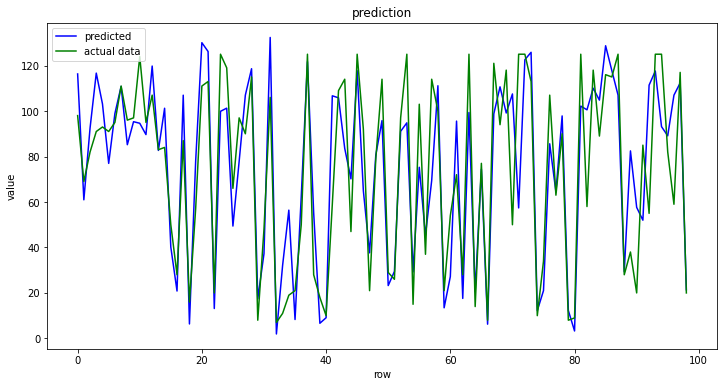

In [16]:
# Test
rms, score = mlps_net.test_net(trained_net)

In [17]:
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

FD001 test RMSE:  21.57572482804387
FD001 test Score:  1558.018355122299


# Inception + NoWeights + No Freeze

In [18]:
# Creo l'oggetto net
mlps_net = network_fit(train_samples, 
                       label_array_train, 
                       test_samples, 
                       label_array_test,
                       model_path = model_path, 
                       model_name = "inception",
                       weights = False,
                       freeze = False,
                       verbose=verbose)
#Train
trained_net = mlps_net.train_net(epochs=epochs, batch_size=batch)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 63, 63, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 63, 63, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 6, 6, 288)    0           mixed2[0][0]                     
__________________________________________________________________________________________________
mixed3 (Concatenate)            (None, 6, 6, 768)    0           activation_214[0][0]             
                                                                 activation_217[0][0]             
                                                                 max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
conv2d_222 (Conv2D)             (None, 6, 6, 128)    98304       mixed3[0][0]                     
__________________________________________________________________________________________________
batch_normalization_222 (BatchN (None, 6, 6, 128)    384         conv2d_222[0][0]                 
__________

Epoch 1/50
140/140 [==============================] - 63s 345ms/step - loss: 7498.4005 - root_mean_squared_error: 86.5847 - mae: 76.0030 - val_loss: 7884.3545 - val_root_mean_squared_error: 88.7939 - val_mae: 78.3330

Epoch 00001: val_root_mean_squared_error improved from inf to 88.79389, saving model to ./temp_net.h5
Epoch 2/50
140/140 [==============================] - 46s 328ms/step - loss: 5428.4921 - root_mean_squared_error: 73.6428 - mae: 62.8202 - val_loss: 4768.6626 - val_root_mean_squared_error: 69.0555 - val_mae: 59.3531

Epoch 00002: val_root_mean_squared_error improved from 88.79389 to 69.05550, saving model to ./temp_net.h5
Epoch 3/50
140/140 [==============================] - 46s 328ms/step - loss: 3502.2429 - root_mean_squared_error: 59.1423 - mae: 49.9246 - val_loss: 2234.0386 - val_root_mean_squared_error: 47.2656 - val_mae: 41.4706

Epoch 00003: val_root_mean_squared_error improved from 69.05550 to 47.26562, saving model to ./temp_net.h5
Epoch 4/50
140/140 [==========


Epoch 00028: val_root_mean_squared_error improved from 29.87851 to 29.87196, saving model to ./temp_net.h5
Epoch 29/50
140/140 [==============================] - 46s 329ms/step - loss: 55.1240 - root_mean_squared_error: 7.4202 - mae: 5.8251 - val_loss: 905.2537 - val_root_mean_squared_error: 30.0874 - val_mae: 24.0173

Epoch 00029: val_root_mean_squared_error did not improve from 29.87196
Epoch 30/50
140/140 [==============================] - 46s 329ms/step - loss: 54.1335 - root_mean_squared_error: 7.3556 - mae: 5.8247 - val_loss: 891.7787 - val_root_mean_squared_error: 29.8627 - val_mae: 23.7732

Epoch 00030: val_root_mean_squared_error improved from 29.87196 to 29.86266, saving model to ./temp_net.h5
Epoch 31/50
140/140 [==============================] - 46s 329ms/step - loss: 57.3221 - root_mean_squared_error: 7.5632 - mae: 5.9602 - val_loss: 910.6885 - val_root_mean_squared_error: 30.1776 - val_mae: 24.1852

Epoch 00031: val_root_mean_squared_error did not improve from 29.86266
E

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0    88.777054     98.0   9.222946     0.094112    9.411170  24.000886
1    65.306198     69.0   3.693802     0.053533    5.353336  24.000886
2    68.869568     82.0  13.130432     0.160127   16.012722  24.000886
3   117.168091     91.0  26.168091     0.287561   28.756145  24.000886
4    94.839195     93.0   1.839195     0.019776    1.977629  24.000886
5    64.009109     91.0  26.990891     0.296603   29.660320  24.000886
6   100.968323     95.0   5.968323     0.062824    6.282445  24.000886
7    95.993713    111.0  15.006287     0.135192   13.519176  24.000886
8    93.560310     96.0   2.439690     0.025413    2.541343  24.000886
9    98.980797     97.0   1.980797     0.020421    2.042058  24.000886
10   96.636642    124.0  27.363358     0.220672   22.067223  24.000886
11   62.732063     95.0  32.267937     0.339662   33.966248  24.000886
12   82.677650    107.0  24.322350     0.227312   22.731167  24.000886
13   9

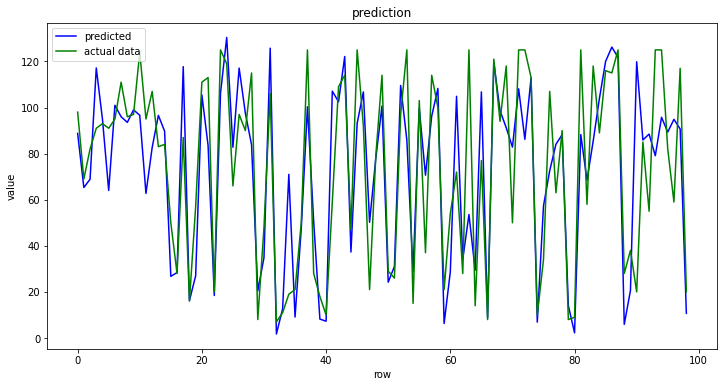

In [19]:
# Test
rms, score = mlps_net.test_net(trained_net)

In [20]:
print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

FD001 test RMSE:  24.000886264967512
FD001 test Score:  22845.484196413458
